In [3]:
import os
import cv2
import pandas as pd
import numpy as np
def onehotc(masks):
    code_mask = []
    for mask in masks:
        nw = list(mask.shape)[:2]
        nw.append(2)
        # print(tuple(nw))
        code = np.zeros(tuple(nw))
        code[:,:,0] = np.array(mask==0, dtype= np.int8)
        code[:,:,1] = np.array(mask==1, dtype= np.int8)

        code_mask.append(code)
    code_mask = np.array(code_mask, dtype= np.int8)
    print(code_mask.shape)
    return code_mask


def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

class loadDataset:
    def __init__(self, csv_file) -> None:
        self.data = pd.read_csv(csv_file)
        print(f"len : {len(self.data)}")
    def getDataset(self, k = 1.0):
        a = []
        b = []
        mx = len(self.data)
        for idx in range(int(mx*k)):
            print(f"Load {idx+1}/{mx} : {((idx+1)/mx)*100:3.2f}%", end="\r" if mx-1 != idx else "\n")
            img_path = self.data.iloc[idx, 1]
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask_rle = self.data.iloc[idx, 2]
            mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
            a.append(cv2.resize(np.array(image), (224,224)))
            # a.append(np.array(image))
            b.append(np.round(cv2.resize(np.array(mask), (224,224))))
            # b.append(np.array(mask)[::2,::2])
            # b.append(np.array(mask, dtype=np.int8))
        print("finish")
        
        return np.array(a), np.array(b)

In [4]:
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plot
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, Normalization, concatenate, Flatten, Dense, Reshape

def Double(conv, unit):
    conv0 = Conv2D(unit, (3, 3), activation='relu', padding='same')(conv)
    conv0 = Dropout(0.2)(conv0)
    conv0 = Conv2D(unit, (3, 3), activation='relu', padding='same')(conv0)
    pool0 = MaxPooling2D((2, 2))(conv0)
    return conv0, pool0

def doubleUp(conv, unit, plus:list):
    up1 = UpSampling2D()(conv)
    plus.insert(0, up1)
    up1 = concatenate(plus, axis=-1)
    conv4 = Conv2D(unit, (3, 3), activation='relu', padding='same')(up1)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(unit, (3, 3), activation='relu', padding='same')(conv4)
    return conv4
def downshift(conv, p = (2,2)):
    return MaxPooling2D(p)(conv)

def unet_model(output_channels: int):

    img_input = Input(shape=(224,224, 3))
    img_input = Normalization()(img_input)

    conv01, pool01 = Double(img_input, 64)
    conv0, pool0 = Double(pool01, 128)
    conv1, pool1 = Double(pool0, 256)
    conv2, pool2 = Double(pool1, 512)

    conv3 = Conv2D(1024,(3, 3), activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv3)
    
    conv4 = doubleUp(conv3, 512, [conv2, downshift(conv1)])
    conv5 = doubleUp(conv4, 256, [conv1, downshift(conv01, (4,4))])
    conv6 = doubleUp(conv5, 128, [conv0])
    conv7 = doubleUp(conv6, 64, [conv01])

    # sk3 = UpSampling2D()(conv3)
    # 2D()(sk3)


    # conv4 = doubleUp(conv3v2, downshift(conv1)])

    # sk4 = UpSampling2D()(conv4)
    # sk4 = UpSampling2D()(sk4)

    # conv5 = doubleUp(conv4, 256, [conv1, downshift(conv0), sk3])

    # sk5 = UpSampling2D()(conv5)
    # sk5 = UpSampling2D()(sk5)
    # sk3 = UpSampling2D()(sk3)

    # conv6 = doubleUp(conv5, 128, [conv0, downshift(conv01), sk3, sk4])

    # sk3 = UpSampling2D()(sk3)
    # sk4 = UpSampling2D()(sk4)

    # conv7 = doubleUp(conv6, 64, [conv01, sk3, sk4, sk5])

    # out = Conv2D(output_channels, (2, 2), activation='softmax', padding='same')(conv7)

    # conv4 = doubleUp(conv3, 512, [conv2, downshift(conv1)])
    # conv5 = doubleUp(conv4, 256, [conv1, downshift(conv0)])
    # conv6 = doubleUp(conv5, 128, [conv0, downshift(conv01)])
    # conv7 = doubleUp(conv6, 64, [conv01])

    out = Conv2D(output_channels, (2, 2), activation='sigmoid', padding='same')(conv7)

    model = Model(img_input, out)
    return model

model = unet_model(1)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 224, 224, 64  0           ['conv2d[1][0]']                 
                                )                                                             

In [6]:
datatset = loadDataset('train.csv').getDataset()
Xtran, Xtest = datatset[0][:7000], datatset[0][7000:]
datatset = onehotc(datatset[1])
datatset = np.expand_dims(datatset,axis=-1)
Ytran, Ytest = datatset[:7000], datatset[7000:]
print(len(Ytran))

len : 7140
Load 7140/7140 : 100.00%
finish
(7140, 224, 224, 2)
7000


In [ ]:
np.max(Ytran)

1

In [ ]:
# class DiceLoss(tf.keras.losses.Loss):
#     def __init__(self, smooth=1e-6, gama=2, reduction=tf.keras.losses.Reduction.AUTO, name="Dice_loss"):
#         super(DiceLoss, self).__init__(reduction=reduction, name=name)
#         self.name = name
#         self.smooth = smooth
#         self.gama = gama

#     def call(self, y_true, y_pred):
#         y_true, y_pred = tf.cast(
#             y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
#         nominator = 2 * \
#             tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
#         denominator = tf.reduce_sum(
#             y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
#         result = 1 - tf.divide(nominator, denominator)
#         return result

In [7]:
class DiceLoss(tf.keras.losses.Loss):
    """Calculates the Dice loss between `y_true` and `y_pred`.

    Args:
        y_true: A tensor of shape `[batch_size, height, width, channels]`.
        y_pred: A tensor of shape `[batch_size, height, width, channels]`.

    Returns:
        A tensor of shape `[batch_size]`.
    """

    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def call(self, y_true, y_pred):
        """Calculates the Dice loss."""
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Calculate the intersection between `y_true` and `y_pred`.
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])

        # Calculate the sum of `y_true` and `y_pred`.
        sum_y_true = tf.reduce_sum(y_true, axis=[1, 2, 3])
        sum_y_pred = tf.reduce_sum(y_pred, axis=[1, 2, 3])

        # Calculate the Dice coefficient.
        dice_coefficient = (2 * intersection) / (sum_y_true + sum_y_pred + self.smooth)

        # Return the Dice loss.
        return 1 - dice_coefficient

    def get_config(self):
        """Returns the configuration of the loss."""
        config = {
            "smooth": self.smooth,
        }
        return config

In [ ]:
model = tf.keras.models.load_model('20230703_ver4.h5')


In [11]:
model = tf.keras.models.load_model("20230703_ver_4__0.h5", custom_objects={"DiceLoss": DiceLoss})


In [9]:

print(Xtran.shape, Ytran.shape)
print(Xtest.shape, Ytest.shape)

model.predict(Xtran[:1])
# model.compile(optimizer=tf.optimizers.Adam(), loss="DiceLoss", metrics=['accuracy'])
# model.compile(optimizer=tf.optimizers.Adam(), loss=DiceLoss(), metrics=['accuracy'])

model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])



(7000, 224, 224, 3) (7000, 224, 224, 2, 1)
(140, 224, 224, 3) (140, 224, 224, 2, 1)
1/1 [==============================] - 4s 4s/step


In [12]:
with tf.device("GPU:0"):
    for i in range(1):
        history = model.fit(Xtran, Ytran, batch_size=15, epochs=1, validation_data=(Xtest,Ytest))
        model.save(f"20230703_ver_4__{i}.h5")

ValueError: in user code:

    File "c:\Users\nare\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\nare\AppData\Local\Temp\ipykernel_14080\2558453080.py", line 22, in call  *
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])

    ValueError: Dimensions must be equal, but are 2 and 224 for '{{node DiceLoss/mul}} = Mul[T=DT_FLOAT](DiceLoss/Cast, model_1/conv2d_29/Softmax)' with input shapes: [?,224,224,2,1], [?,224,224,2].


In [ ]:
model = tf.keras.models.load_model("20230703_ver_4__0.h5", custom_objects={"DiceLoss": DiceLoss})

1/1 [==============================] - 0s 17ms/step
(224, 224, 3)


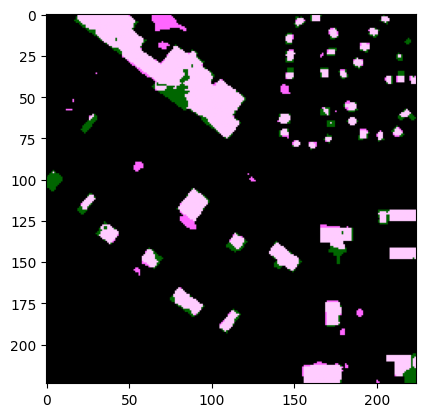

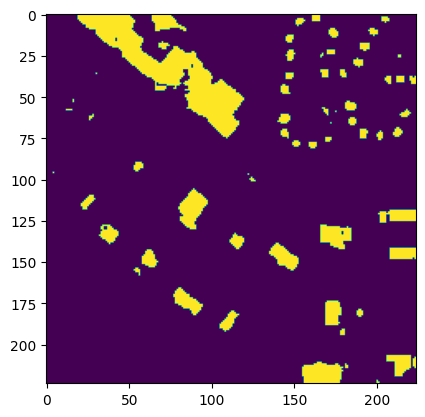

In [ ]:
codef = 10
a = Xtest[codef:codef+1]
b = Ytest[codef:codef+1]
# print(model.predict(a)[0].shape)
hj = np.argmax(model.predict(a)[0], axis=-1)
cb = np.zeros((224,224,3))
cb[:,:,1] = ((b[0][:,:,0]) + hj) /2.5
cb[:,:,0] = hj
cb[:,:,2] = hj
# plot.imshow(model.predict(a)[0])
# plot.imshow(np.argmax(model.predict(a)[0], axis=-1))
print(cb.shape)
plot.figure(1)
plot.imshow(cb)
plot.figure(2)
plot.imshow(hj)
plot.show()

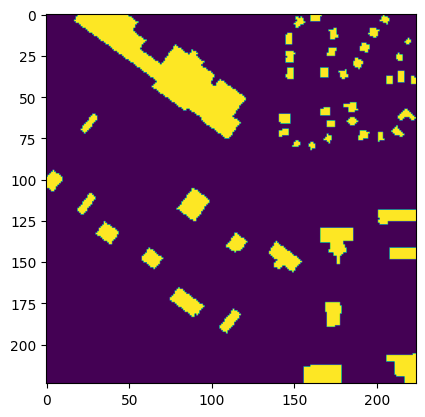

In [ ]:
plot.imshow(b[0])
plot.show()


In [ ]:
codef = 0
a = Xtest
b = Ytest
DiceLoss()(b,model.predict(a))

5/5 [==============================] - 4s 427ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.88539535>

In [ ]:

# RLE 인코딩 함수
import csv
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


class ScoreData:
    def __init__(self, csv_file) -> None:
        self.data = pd.read_csv(csv_file)
        print(f"len : {len(self.data)}")
        
    def getData(self, model, k = 1.0):
        with open('cv.csv', 'w', newline='') as f:
            writer = csv.writer(f)
            data = ['img_id','mask_rle']
            writer.writerow(data)
            a = []
            mx = len(self.data)
            for idx in range(int(mx*k)):
                a=[]
                print(f"Load {idx+1}/{mx} : {((idx+1)/mx)*100:3.2f}%", end="\r" if mx-1 != idx else "\n")
                img_path = self.data.iloc[idx, 1]
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                a.append(self.data.iloc[idx, 0])
                b = rle_encode(np.argmax(model.predict(np.array([image]), verbose=0)[0], axis=-1))
                a.append(b if b != '' else '-1')
                writer.writerow(a)

        print("finish")

kl = ScoreData("./test.csv")
test = kl.getData(model= model, k = 1.0)

len : 60640


KeyboardInterrupt: 

In [ ]:

    # sk3 = UpSampling2D()(conv3)
    # sk3 = UpSampling2D()(sk3)


    # conv4 = doubleUp(conv3, 512, [conv2, downshift(conv1)])

    # sk4 = UpSampling2D()(conv4)
    # sk4 = UpSampling2D()(sk4)

    # conv5 = doubleUp(conv4, 256, [conv1, downshift(conv0), sk3])

    # sk5 = UpSampling2D()(conv5)
    # sk5 = UpSampling2D()(sk5)
    # sk3 = UpSampling2D()(sk3)

    # conv6 = doubleUp(conv5, 128, [conv0, downshift(conv01), sk3, sk4])

    # sk3 = UpSampling2D()(sk3)
    # sk4 = UpSampling2D()(sk4)

    # conv7 = doubleUp(conv6, 64, [conv01, sk3, sk4, sk5])

    # out = Conv2D(output_channels, (2, 2), activation='softmax', padding='same')(conv7)
